# 都道府県×年月（target_ym）分析

**目的**: 都道府県とtarget_ym（予測対象の年月）の2軸でデータを分析し、時系列トレンドと地域格差を把握する

**このノートブックで行うこと**:
1. target_ymの確認（2019/01, 2019/07, ..., 2022/07の8期間）
2. 都道府県×target_ymのデータ数分布（ヒートマップ）
3. 都道府県×target_ymの平均賃料分布
4. 時系列トレンド（主要都道府県）
5. 1月 vs 7月の季節性分析
6. モデリングへの示唆

## セットアップ

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root / "04_src"))
os.chdir(project_root)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# フォント設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
try:
    import japanize_matplotlib
    japanize_matplotlib.japanize()
except ImportError:
    plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# DataLoader
from data.loader import DataLoader
from utils.config import load_config

print("✓ セットアップ完了")

✓ セットアップ完了


## 1. データ読み込みとtarget_ymの確認

In [2]:
# データ読み込み（prefecture_name, city_nameが自動追加される）
data_config = load_config("data")
loader = DataLoader(data_config)

train = loader.load_train()
test = loader.load_test()

print(f"訓練データ: {train.shape}")
print(f"テストデータ: {test.shape}")
print(f"\n追加された住所カラム: {[col for col in train.columns if col in ['prefecture_name', 'city_name']]}")

訓練データ: (363924, 151)
テストデータ: (112437, 151)

追加された住所カラム: ['prefecture_name', 'city_name']


In [3]:
# target_ymの値を確認
print("[Train target_ymの分布]")
target_ym_dist = train.group_by('target_ym').agg(pl.len().alias('count')).sort('target_ym')
print(target_ym_dist)

print("\n[データ期間]")
print("Train: 2019年1月/7月 〜 2022年1月/7月（8期間）")
print("Test: 2023年1月/7月（予測対象、target_ym不明）")

[Train target_ymの分布]
shape: (8, 2)
┌───────────┬───────┐
│ target_ym ┆ count │
│ ---       ┆ ---   │
│ i64       ┆ u32   │
╞═══════════╪═══════╡
│ 201901    ┆ 36516 │
│ 201907    ┆ 45775 │
│ 202001    ┆ 51452 │
│ 202007    ┆ 52514 │
│ 202101    ┆ 45459 │
│ 202107    ┆ 42642 │
│ 202201    ┆ 43103 │
│ 202207    ┆ 46463 │
└───────────┴───────┘

[データ期間]
Train: 2019年1月/7月 〜 2022年1月/7月（8期間）
Test: 2023年1月/7月（予測対象、target_ym不明）


In [4]:
# target_ymから年と月を抽出
train = train.with_columns([
    (pl.col('target_ym') // 100).alias('target_year'),
    (pl.col('target_ym') % 100).alias('target_month')
])

print("[抽出した年月カラム]")
print(train.select(['target_ym', 'target_year', 'target_month']).head(10))

[抽出した年月カラム]
shape: (10, 3)
┌───────────┬─────────────┬──────────────┐
│ target_ym ┆ target_year ┆ target_month │
│ ---       ┆ ---         ┆ ---          │
│ i64       ┆ i64         ┆ i64          │
╞═══════════╪═════════════╪══════════════╡
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
│ 201901    ┆ 2019        ┆ 1            │
└───────────┴─────────────┴──────────────┘


## 2. 都道府県×target_ym データ数分布

In [5]:
# 都道府県×target_ymのクロス集計
pref_ym_count = (
    train.group_by(['prefecture_name', 'target_ym'])
    .agg(pl.len().alias('count'))
    .sort(['prefecture_name', 'target_ym'])
)

print("[都道府県×target_ym 集計（サンプル）]")
print(pref_ym_count.head(20))
print(f"\n総パターン数: {len(pref_ym_count)}")

[都道府県×target_ym 集計（サンプル）]
shape: (20, 3)
┌─────────────────┬───────────┬───────┐
│ prefecture_name ┆ target_ym ┆ count │
│ ---             ┆ ---       ┆ ---   │
│ str             ┆ i64       ┆ u32   │
╞═════════════════╪═══════════╪═══════╡
│ 三重県          ┆ 201901    ┆ 74    │
│ 三重県          ┆ 201907    ┆ 112   │
│ 三重県          ┆ 202001    ┆ 150   │
│ 三重県          ┆ 202007    ┆ 139   │
│ 三重県          ┆ 202101    ┆ 163   │
│ …               ┆ …         ┆ …     │
│ 京都府          ┆ 202207    ┆ 1607  │
│ 佐賀県          ┆ 201901    ┆ 88    │
│ 佐賀県          ┆ 201907    ┆ 101   │
│ 佐賀県          ┆ 202001    ┆ 110   │
│ 佐賀県          ┆ 202007    ┆ 95    │
└─────────────────┴───────────┴───────┘

総パターン数: 376


In [6]:
# データ数が多い上位15都道府県を抽出
top_15_prefs = (
    train.group_by('prefecture_name')
    .agg(pl.len().alias('total'))
    .sort('total', descending=True)
    .head(15)['prefecture_name']
    .to_list()
)

print("[データ数上位15都道府県]")
for i, pref in enumerate(top_15_prefs, 1):
    count = train.filter(pl.col('prefecture_name') == pref).height
    print(f"{i:2d}. {pref:10s}: {count:7,d} 件")

[データ数上位15都道府県]


 1. 東京都       :  66,434 件


 2. 大阪府       :  44,752 件


 3. 神奈川県      :  42,228 件
 4. 埼玉県       :  30,930 件


 5. 千葉県       :  23,926 件
 6. 兵庫県       :  22,778 件


 7. 愛知県       :  20,826 件
 8. 福岡県       :  15,481 件
 9. 京都府       :  13,018 件
10. 静岡県       :   9,544 件
11. 宮城県       :   6,034 件
12. 北海道       :   6,027 件
13. 茨城県       :   5,525 件
14. 滋賀県       :   5,252 件
15. 広島県       :   4,873 件


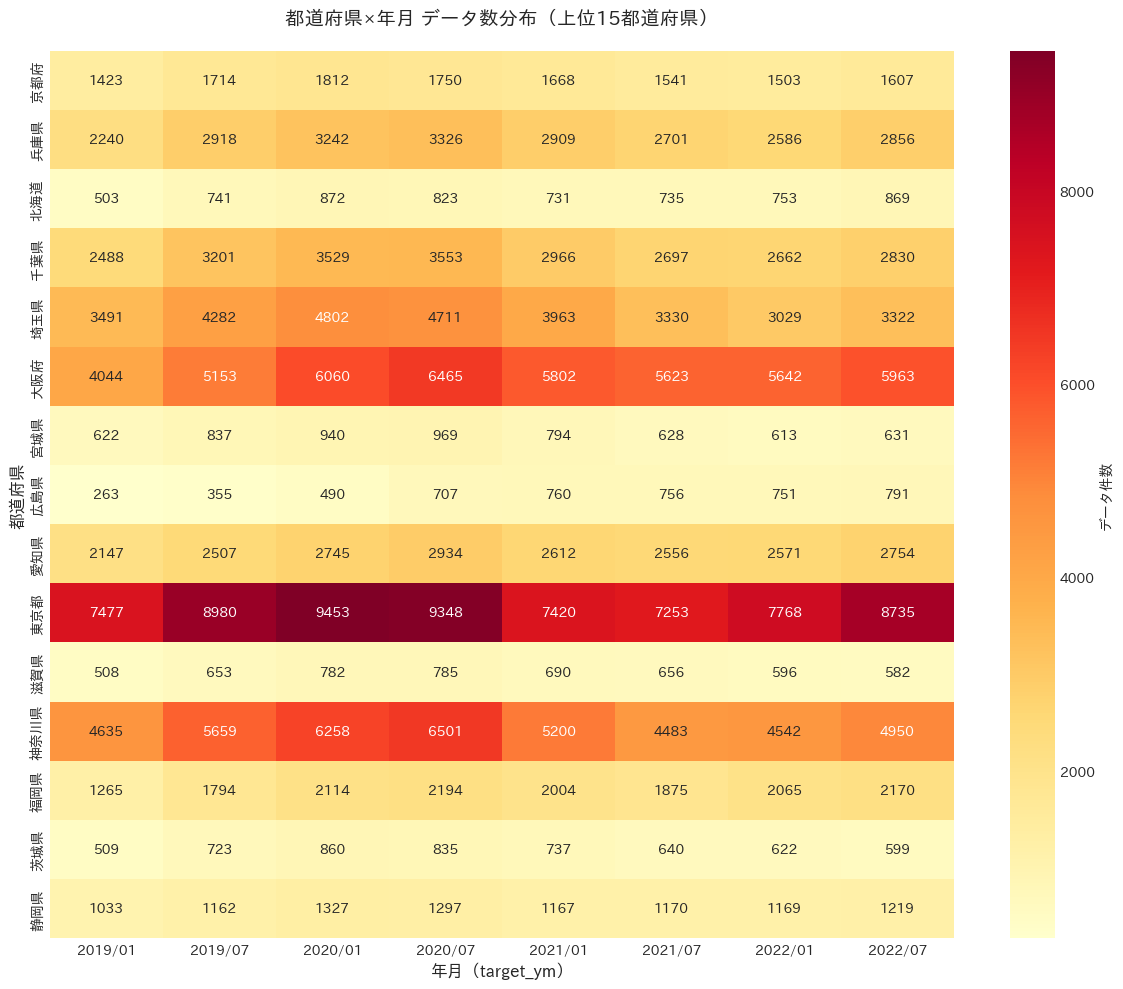

In [7]:
# ヒートマップ用にピボット
pref_ym_pivot = pref_ym_count.pivot(
    index='prefecture_name',
    columns='target_ym',
    values='count'
).fill_null(0)

# 上位15都道府県でヒートマップ
top_15_pivot = pref_ym_pivot.filter(pl.col('prefecture_name').is_in(top_15_prefs))
top_15_pd = top_15_pivot.to_pandas().set_index('prefecture_name')

# カラム名を見やすく変換（201901 → 2019/01）
top_15_pd.columns = [f"{int(col)//100}/{int(col)%100:02d}" for col in top_15_pd.columns]

# ヒートマップ描画
plt.figure(figsize=(12, 10))
sns.heatmap(top_15_pd, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'データ件数'})
plt.title('都道府県×年月 データ数分布（上位15都道府県）', fontsize=14, pad=20)
plt.xlabel('年月（target_ym）', fontsize=12)
plt.ylabel('都道府県', fontsize=12)
plt.tight_layout()
plt.show()

## 3. 都道府県×target_ym 平均賃料分布

In [8]:
# 都道府県×target_ymの平均賃料
pref_ym_price = (
    train.group_by(['prefecture_name', 'target_ym'])
    .agg([
        pl.len().alias('count'),
        pl.col('money_room').mean().alias('mean_price'),
        pl.col('money_room').median().alias('median_price')
    ])
    .sort(['prefecture_name', 'target_ym'])
)

print("[都道府県×target_ym 平均賃料（サンプル）]")
print(pref_ym_price.head(20))

[都道府県×target_ym 平均賃料（サンプル）]
shape: (20, 5)
┌─────────────────┬───────────┬───────┬─────────────┬──────────────┐
│ prefecture_name ┆ target_ym ┆ count ┆ mean_price  ┆ median_price │
│ ---             ┆ ---       ┆ ---   ┆ ---         ┆ ---          │
│ str             ┆ i64       ┆ u32   ┆ f64         ┆ f64          │
╞═════════════════╪═══════════╪═══════╪═════════════╪══════════════╡
│ 三重県          ┆ 201901    ┆ 74    ┆ 1.5396e7    ┆ 1.38e7       │
│ 三重県          ┆ 201907    ┆ 112   ┆ 1.5938125e7 ┆ 1.398e7      │
│ 三重県          ┆ 202001    ┆ 150   ┆ 1.6527e7    ┆ 1.449e7      │
│ 三重県          ┆ 202007    ┆ 139   ┆ 1.6787e7    ┆ 1.48e7       │
│ 三重県          ┆ 202101    ┆ 163   ┆ 1.7203e7    ┆ 1.499e7      │
│ …               ┆ …         ┆ …     ┆ …           ┆ …            │
│ 京都府          ┆ 202207    ┆ 1607  ┆ 2.6117e7    ┆ 2e7          │
│ 佐賀県          ┆ 201901    ┆ 88    ┆ 1.5828e7    ┆ 1.5e7        │
│ 佐賀県          ┆ 201907    ┆ 101   ┆ 1.6983e7    ┆ 1.64e7       │
│ 佐賀県          

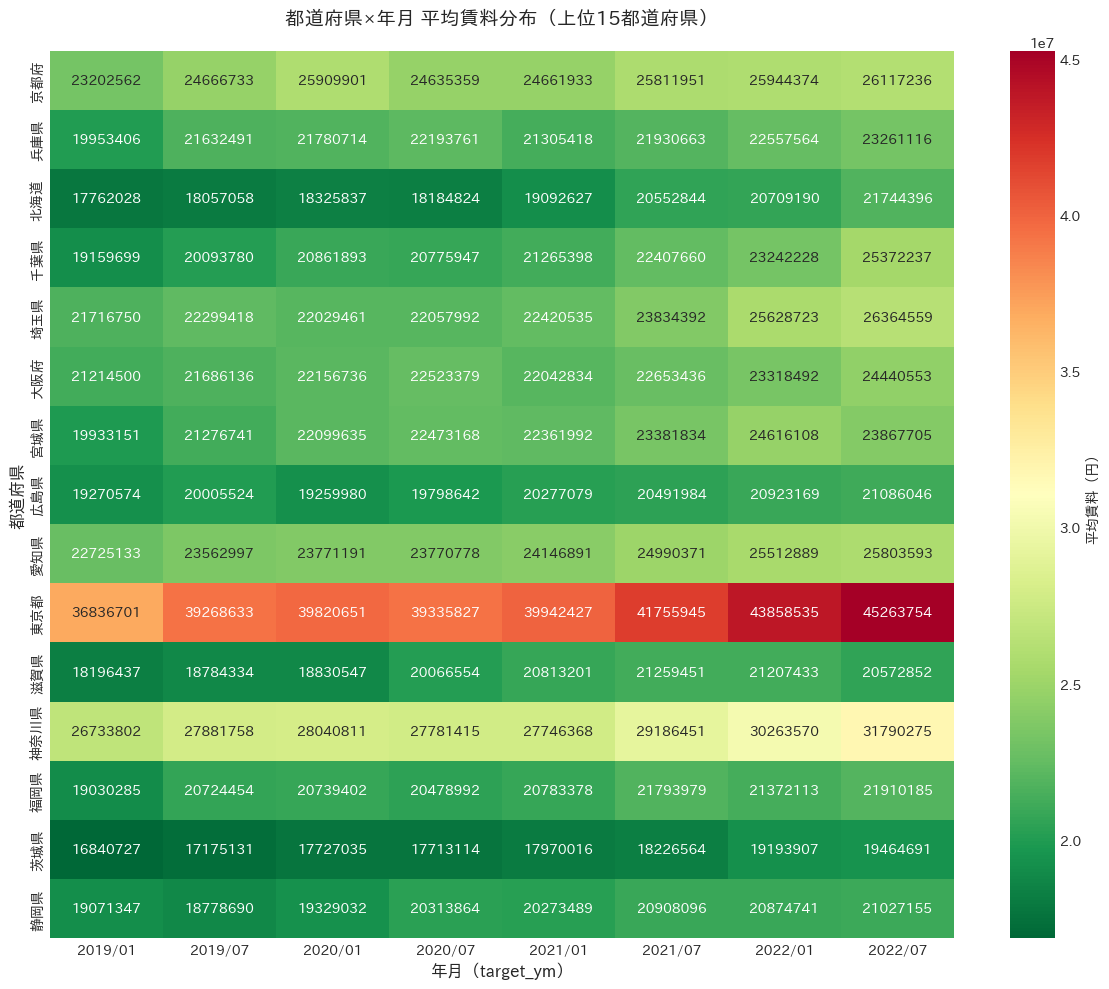

In [9]:
# 平均賃料ヒートマップ（上位15都道府県）
pref_ym_price_pivot = pref_ym_price.pivot(
    index='prefecture_name',
    columns='target_ym',
    values='mean_price'
).fill_null(0)

top_15_price_pivot = pref_ym_price_pivot.filter(pl.col('prefecture_name').is_in(top_15_prefs))
top_15_price_pd = top_15_price_pivot.to_pandas().set_index('prefecture_name')
top_15_price_pd.columns = [f"{int(col)//100}/{int(col)%100:02d}" for col in top_15_price_pd.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(top_15_price_pd, annot=True, fmt='.0f', cmap='RdYlGn_r', cbar_kws={'label': '平均賃料（円）'})
plt.title('都道府県×年月 平均賃料分布（上位15都道府県）', fontsize=14, pad=20)
plt.xlabel('年月（target_ym）', fontsize=12)
plt.ylabel('都道府県', fontsize=12)
plt.tight_layout()
plt.show()

## 4. 主要都道府県の時系列トレンド

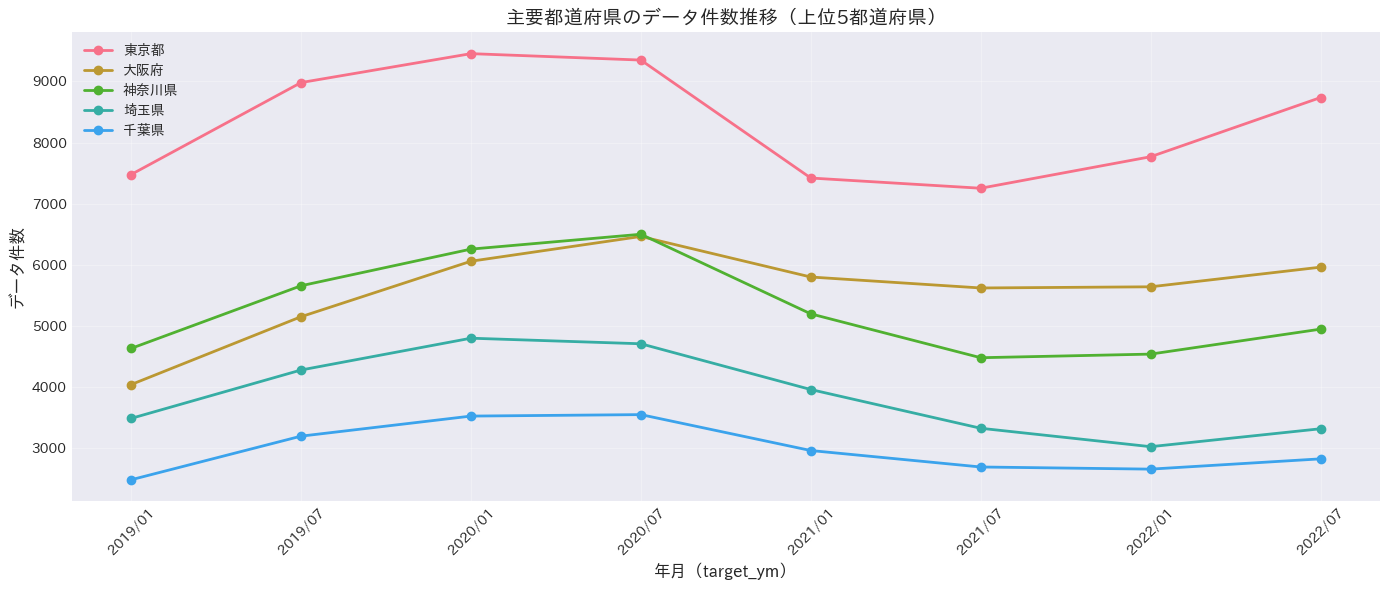

In [10]:
# 上位5都道府県のデータ数推移
top_5_prefs = top_15_prefs[:5]

fig, ax = plt.subplots(figsize=(14, 6))

for pref in top_5_prefs:
    pref_data = pref_ym_count.filter(pl.col('prefecture_name') == pref).sort('target_ym')
    # target_ymをラベル化
    labels = [f"{int(ym)//100}/{int(ym)%100:02d}" for ym in pref_data['target_ym']]
    ax.plot(labels, pref_data['count'], marker='o', label=pref, linewidth=2)

ax.set_xlabel('年月（target_ym）', fontsize=12)
ax.set_ylabel('データ件数', fontsize=12)
ax.set_title('主要都道府県のデータ件数推移（上位5都道府県）', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

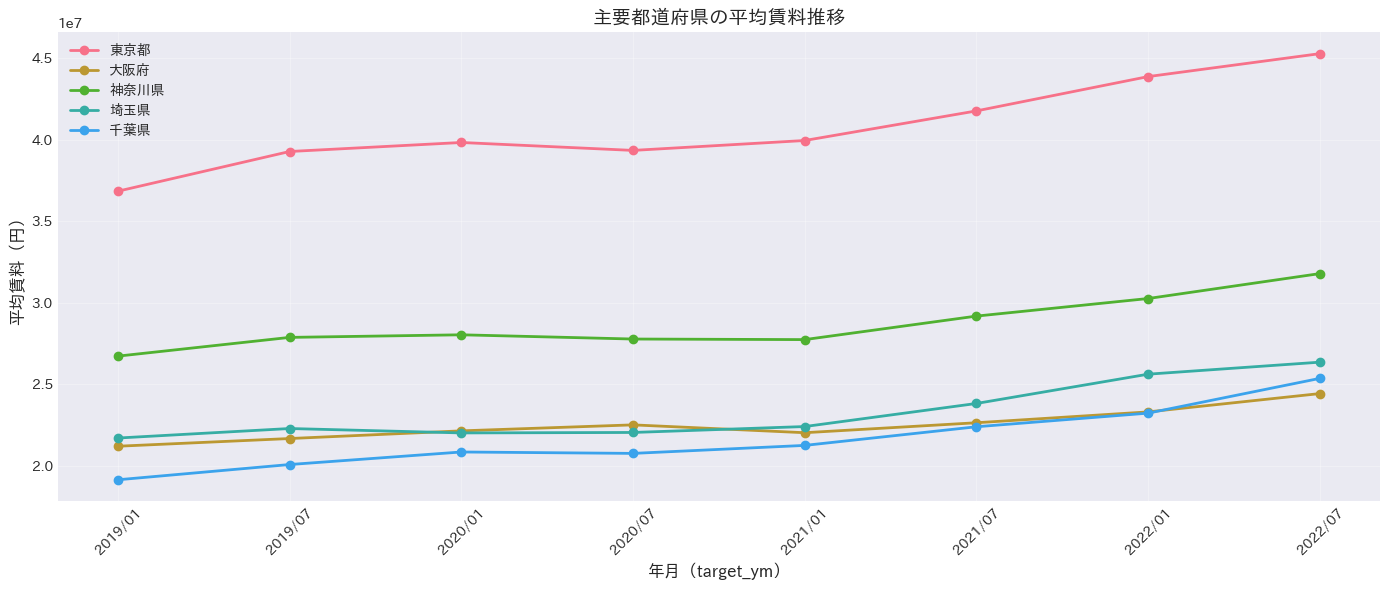

In [11]:
# 上位5都道府県の平均賃料推移
fig, ax = plt.subplots(figsize=(14, 6))

for pref in top_5_prefs:
    pref_data = pref_ym_price.filter(pl.col('prefecture_name') == pref).sort('target_ym')
    labels = [f"{int(ym)//100}/{int(ym)%100:02d}" for ym in pref_data['target_ym']]
    ax.plot(labels, pref_data['mean_price'], marker='o', label=pref, linewidth=2)

ax.set_xlabel('年月（target_ym）', fontsize=12)
ax.set_ylabel('平均賃料（円）', fontsize=12)
ax.set_title('主要都道府県の平均賃料推移', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. 季節性分析（1月 vs 7月）

In [12]:
# 1月と7月でデータを分割
jan_data = train.filter(pl.col('target_month') == 1)
jul_data = train.filter(pl.col('target_month') == 7)

print(f"1月データ: {jan_data.height:,} 件")
print(f"7月データ: {jul_data.height:,} 件")

1月データ: 176,530 件
7月データ: 187,394 件


In [13]:
# 都道府県別の1月・7月平均賃料比較
jan_price = (
    jan_data.group_by('prefecture_name')
    .agg(pl.col('money_room').mean().alias('jan_price'))
)

jul_price = (
    jul_data.group_by('prefecture_name')
    .agg(pl.col('money_room').mean().alias('jul_price'))
)

seasonal_compare = jan_price.join(jul_price, on='prefecture_name')
seasonal_compare = seasonal_compare.with_columns(
    (pl.col('jul_price') - pl.col('jan_price')).alias('diff'),
    ((pl.col('jul_price') - pl.col('jan_price')) / pl.col('jan_price') * 100).alias('diff_pct')
).sort('diff', descending=True)

print("[1月 vs 7月 平均賃料比較（上位10都道府県）]")
print("※ diff = 7月 - 1月（正の値なら7月が高い）\n")
print(seasonal_compare.head(10))

[1月 vs 7月 平均賃料比較（上位10都道府県）]
※ diff = 7月 - 1月（正の値なら7月が高い）

shape: (10, 5)
┌─────────────────┬───────────┬───────────┬───────────────┬──────────┐
│ prefecture_name ┆ jan_price ┆ jul_price ┆ diff          ┆ diff_pct │
│ ---             ┆ ---       ┆ ---       ┆ ---           ┆ ---      │
│ str             ┆ f64       ┆ f64       ┆ f64           ┆ f64      │
╞═════════════════╪═══════════╪═══════════╪═══════════════╪══════════╡
│ 大分県          ┆ 2.1706e7  ┆ 2.2922e7  ┆ 1.2160e6      ┆ 5.602186 │
│ 東京都          ┆ 4.0131e7  ┆ 4.1339e7  ┆ 1.2080e6      ┆ 3.010076 │
│ 青森県          ┆ 1.5265e7  ┆ 1.6379e7  ┆ 1.1139e6      ┆ 7.296998 │
│ 沖縄県          ┆ 3.4796e7  ┆ 3.5909e7  ┆ 1.1129e6      ┆ 3.198345 │
│ 山梨県          ┆ 1.8611e7  ┆ 1.9629e7  ┆ 1.0180e6      ┆ 5.469996 │
│ 千葉県          ┆ 2.1145e7  ┆ 2.2016e7  ┆ 870514.881925 ┆ 4.116859 │
│ 神奈川県        ┆ 2.8162e7  ┆ 2.9018e7  ┆ 856124.002177 ┆ 3.039966 │
│ 岐阜県          ┆ 1.6510e7  ┆ 1.7358e7  ┆ 847941.319501 ┆ 5.135948 │
│ 兵庫県          ┆ 2.1465e7  ┆ 

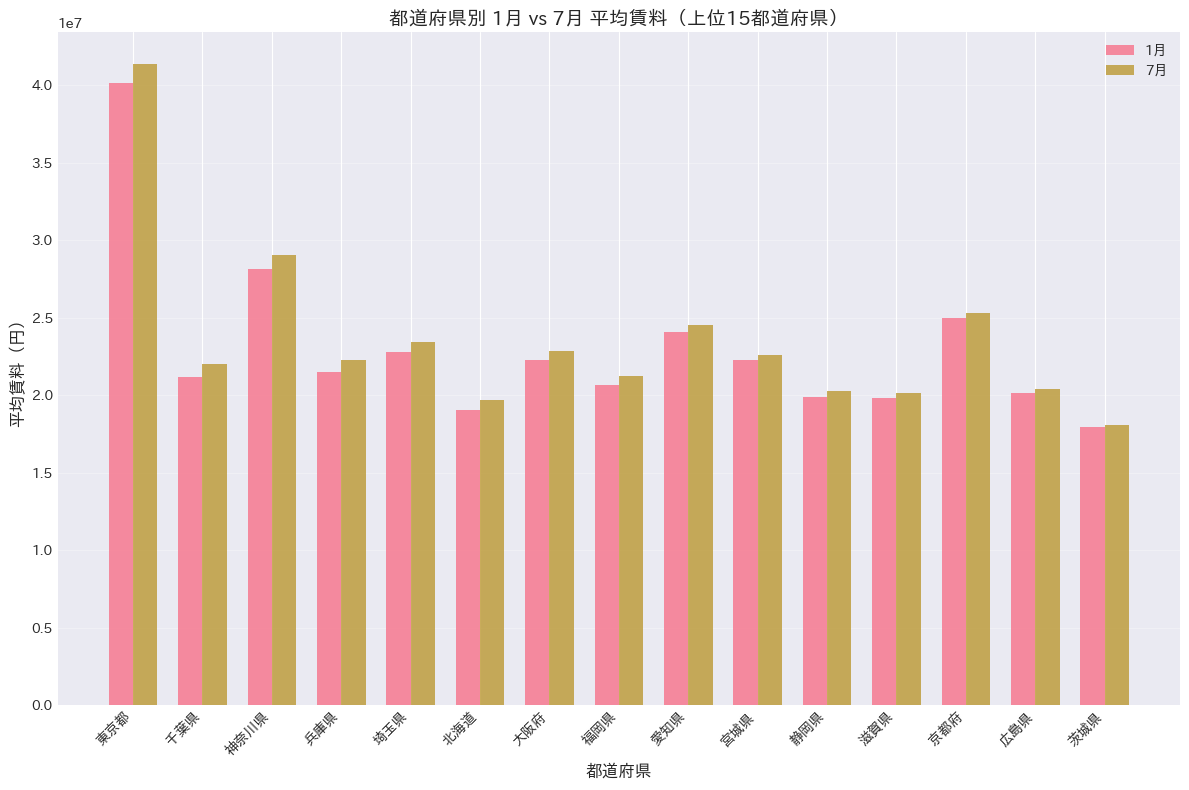

In [14]:
# 季節性の可視化（上位15都道府県）
top_15_seasonal = seasonal_compare.filter(pl.col('prefecture_name').is_in(top_15_prefs))
top_15_seasonal_pd = top_15_seasonal.to_pandas().set_index('prefecture_name')

fig, ax = plt.subplots(figsize=(12, 8))
x = range(len(top_15_seasonal_pd))
width = 0.35

ax.bar([i - width/2 for i in x], top_15_seasonal_pd['jan_price'], width, label='1月', alpha=0.8)
ax.bar([i + width/2 for i in x], top_15_seasonal_pd['jul_price'], width, label='7月', alpha=0.8)

ax.set_xlabel('都道府県', fontsize=12)
ax.set_ylabel('平均賃料（円）', fontsize=12)
ax.set_title('都道府県別 1月 vs 7月 平均賃料（上位15都道府県）', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(top_15_seasonal_pd.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# 全体の季節性統計
print("[全体の季節性統計]")
print(f"1月平均賃料: {jan_data['money_room'].mean():,.0f} 円")
print(f"7月平均賃料: {jul_data['money_room'].mean():,.0f} 円")
print(f"差額: {jul_data['money_room'].mean() - jan_data['money_room'].mean():,.0f} 円")
print(f"差額率: {(jul_data['money_room'].mean() - jan_data['money_room'].mean()) / jan_data['money_room'].mean() * 100:.2f}%")

[全体の季節性統計]
1月平均賃料: 25,561,484 円
7月平均賃料: 26,267,601 円
差額: 706,116 円
差額率: 2.76%


## 6. 年次トレンド分析

In [16]:
# 年別の平均賃料推移
year_price = (
    train.group_by('target_year')
    .agg([
        pl.len().alias('count'),
        pl.col('money_room').mean().alias('mean_price'),
        pl.col('money_room').median().alias('median_price')
    ])
    .sort('target_year')
)

print("[年別 平均賃料推移]")
print(year_price)

[年別 平均賃料推移]
shape: (4, 4)
┌─────────────┬────────┬────────────┬──────────────┐
│ target_year ┆ count  ┆ mean_price ┆ median_price │
│ ---         ┆ ---    ┆ ---        ┆ ---          │
│ i64         ┆ u32    ┆ f64        ┆ f64          │
╞═════════════╪════════╪════════════╪══════════════╡
│ 2019        ┆ 82291  ┆ 2.4946e7   ┆ 2.1e7        │
│ 2020        ┆ 103966 ┆ 2.5367e7   ┆ 2.16e7       │
│ 2021        ┆ 88101  ┆ 2.5598e7   ┆ 2.18e7       │
│ 2022        ┆ 89566  ┆ 2.7795e7   ┆ 2.35e7       │
└─────────────┴────────┴────────────┴──────────────┘


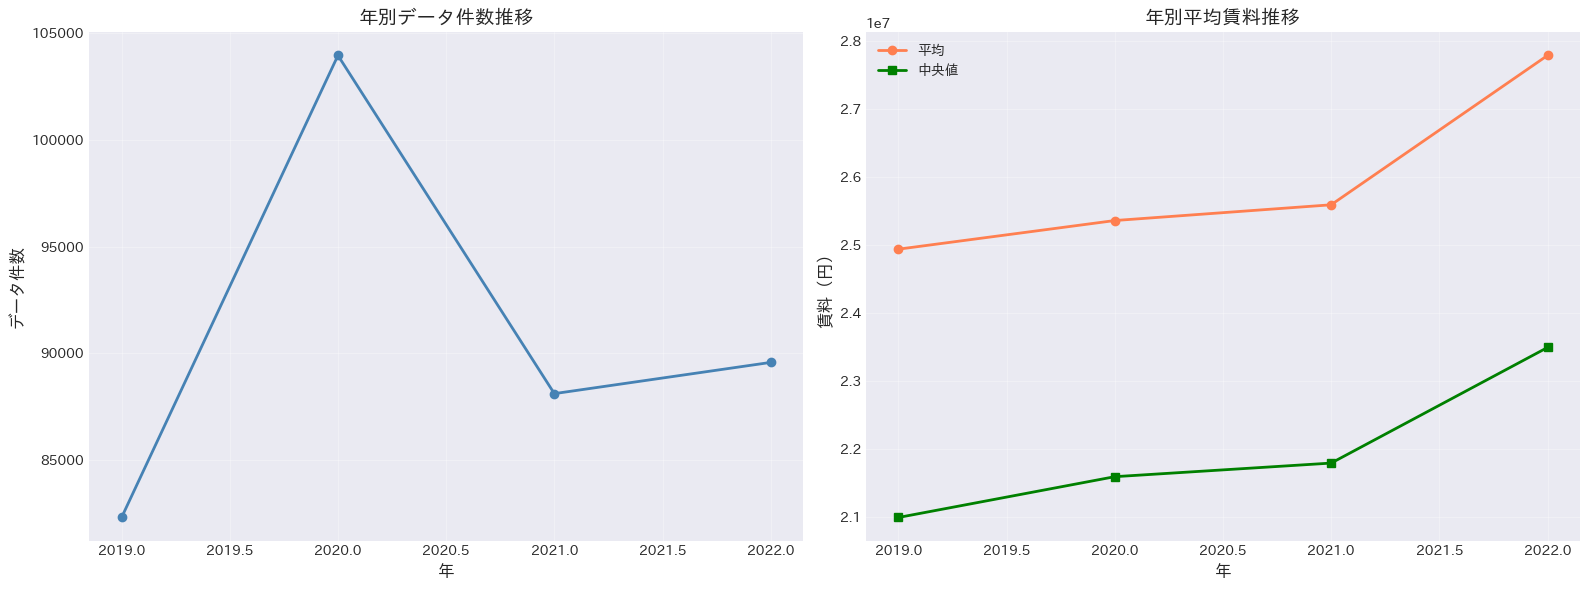

In [17]:
# 年次トレンドの可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# データ件数の推移
ax1.plot(year_price['target_year'], year_price['count'], marker='o', linewidth=2, color='steelblue')
ax1.set_xlabel('年', fontsize=12)
ax1.set_ylabel('データ件数', fontsize=12)
ax1.set_title('年別データ件数推移', fontsize=14)
ax1.grid(alpha=0.3)

# 平均賃料の推移
ax2.plot(year_price['target_year'], year_price['mean_price'], marker='o', linewidth=2, color='coral', label='平均')
ax2.plot(year_price['target_year'], year_price['median_price'], marker='s', linewidth=2, color='green', label='中央値')
ax2.set_xlabel('年', fontsize=12)
ax2.set_ylabel('賃料（円）', fontsize=12)
ax2.set_title('年別平均賃料推移', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. まとめと示唆

### 発見事項

#### データ分布の特徴
- **時系列**: Train は 2019/01 〜 2022/07 の8期間（1月・7月のみ）
- **Test 予測対象**: 2023年1月または7月（target_ym不明）
- **地域偏り**: 上位都道府県にデータが集中

#### 時系列トレンド
- 2019年→2022年で賃料が上昇傾向にあるか？
- 都道府県ごとにトレンドが異なるか？

#### 季節性（1月 vs 7月）
- 1月と7月で賃料に差があるか？
- 都道府県によって季節性の大きさが異なるか？

### モデリングへの示唆

1. **特徴量エンジニアリング**
   - [ ] target_ymから年・月を抽出して特徴量化
   - [ ] 都道府県×年月の交互作用特徴量
   - [ ] 都道府県別の時系列トレンド特徴量（前期比、前年比など）
   - [ ] 季節性特徴量（1月/7月フラグ）

2. **クロスバリデーション戦略**
   - [ ] 時系列分割（2019-2021年でTrain、2022年でValidation）
   - [ ] 都道府県を考慮したStratifiedKFold

3. **モデル選択**
   - [ ] LightGBM/XGBoostなどの勾配ブースティング
   - [ ] 都道府県別モデル vs 全体モデル

4. **予測時の注意点**
   - Test は 2023年1月/7月だが、どちらか不明
   - 両方のケースで予測して提出時に判断する必要があるかも？